In [ ]:
NAME = "Ngo Nhat Hung Tran"
NET_ID = "nt423"

# Setup

In [ ]:
import zipfile
import matplotlib.pyplot as plt
import random
import collections
import numpy as np
import zipfile
import torch
import os
import torch.nn as nn
import torch.nn.functional as F

from bs4 import BeautifulSoup
import urllib.request
import requests

!pip install pretty_midi
!pip install music21
import pretty_midi
import music21

import pickle
import time
import itertools

def seed(seed):
  torch.manual_seed(seed)
  np.random.seed(seed)

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Good to go!


In [ ]:
def download_dataset(folder_dir):
  url = "http://ragtimemusic.com/midifile/"
  hdr = { 'User-Agent' : 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)' }

  req = urllib.request.Request(url, headers=hdr)
  html_page = urllib.request.urlopen(req)
  soup = BeautifulSoup(html_page, "html.parser")
  hrefs = [link.get("href") for link in soup.findAll("a")]
  names = [href for href in hrefs if ".mid" in href]

  if not os.path.exists(folder_dir):
      os.makedirs(folder_dir)

  for name in names:
      file_name = os.path.join(folder_dir, name)
      if not os.path.exists(file_name):
          link = url + name
          response = requests.get(link, headers=hdr)
          if response.status_code == 200:
              with open(file_name, 'wb') as f:
                  f.write(response.content)
          else:
              print("Bad response code :", response.status_code, link)

download_dataset("dataset/orig")

In [ ]:
def transpose_dataset(orig_folder, trps_folder):
  orig_names = os.listdir(orig_folder)
  orig_names.sort()
  if not os.path.exists(trps_folder):
    os.makedirs(trps_folder)
  for i, orig_name in enumerate(orig_names):
    trps_dir = os.path.join(trps_folder, orig_name)
    if not os.path.exists(trps_dir):
      orig_dir = os.path.join(orig_folder, orig_name)
      score = music21.converter.parse(orig_dir)
      try:
        key = score.analyze('key')
        if key.mode == "major":
          half_steps = music21.interval.Interval(key.tonic, music21.pitch.Pitch('C'))
        elif key.mode == "minor":
          half_steps = music21.interval.Interval(key.tonic, music21.pitch.Pitch('A'))
        new_score = score.transpose(half_steps)
        new_key = new_score.analyze('key')
        print(i, orig_name, key.tonic.name, key.mode, new_key.tonic.name, new_key.mode)
        new_score.write('midi', trps_dir)
      except Exception as e:
        print(i, orig_name, str(e))

transpose_dataset("dataset/orig", "dataset/trps")

274 pastime2.mid 'Unpitched' object has no attribute 'pitch'
306 ragdance.mid 'PercussionChord' object has no attribute 'pitch'


In [ ]:
def download_processor(file_name):
  if not os.path.exists(file_name):
    DATA_URL = 'https://raw.githubusercontent.com/jason9693/midi-neural-processor/master/processor.py'
    r = requests.get(DATA_URL)

    with open(file_name, 'w') as f:
      f.write(r.text)

download_processor('midi_neural_processor.py')

In [ ]:
from midi_neural_processor import encode_midi, decode_midi

MAX_LEN = 600
pad_token = 0
bos_token = 1
eos_token = 2
batch_size = 32

def encode_midis(folder_dir, enc_dir):
  if os.path.exists(enc_dir):
    return pickle.load(open(enc_dir, 'rb'))
  else:
    file_names = os.listdir(folder_dir)
    file_names.sort()
    file_dirs = [os.path.join(folder_dir, file_name) for file_name in file_names]
    enc_midis = []
    for i, file_dir in enumerate(file_dirs):
        try:
            raw_enc_midi = encode_midi(file_dir)
            enc_midi = [bos_token] + (torch.tensor(raw_enc_midi) + 3).tolist() + [eos_token]
            enc_midis.append(enc_midi)
        except Exception as e:
            print(i, file_dir, str(e))
    pickle.dump(enc_midis, open(enc_dir, 'wb'))
    return enc_midis

def build_tensor(enc_midis):
  segments = []
  for enc_midi in enc_midis:
    for i in range(0, len(enc_midi), MAX_LEN):
      segment = enc_midi[i:i+MAX_LEN]
      segments.append(segment + [pad_token] * (MAX_LEN - len(segment)))
  array = torch.tensor(segments)
  valid_len = (array != pad_token).sum(1)
  return array, valid_len 

def load_data(folder_dir, file_dir, batch_size=1):
  enc_midis = encode_midis(folder_dir, file_dir)
  array, valid_len = build_tensor(enc_midis)
  data = torch.utils.data.TensorDataset(array, valid_len)
  iterations = torch.utils.data.DataLoader(data, batch_size, shuffle=True)
  return iterations

train_iter = load_data('dataset/orig', 'dataset/enc_midis_orig.pkl', batch_size)

def load_debug(folder_dir, file_dir, batch_size=1):
  enc_midis = encode_midis(folder_dir, file_dir)
  array, valid_len = build_tensor(enc_midis[0:1])
  data = torch.utils.data.TensorDataset(array[0:1], valid_len[0:1])
  iterations = torch.utils.data.DataLoader(data, batch_size, shuffle=True)
  return iterations

debug_iter = load_debug('dataset/orig', 'dataset/enc_midis_orig.pkl', batch_size=1)

In [ ]:
def dataset_summary(folder_dir, file_name):
  file_names = os.listdir(folder_dir)
  file_dirs = [os.path.join(folder_dir, file_name) for file_name in file_names]
  midi_objects = [pretty_midi.PrettyMIDI(file_dir) for file_dir in file_dirs]
  lens_sec = [midi_object.get_end_time() for midi_object in midi_objects]
  enc_midis = encode_midis(folder_dir, file_name)
  lens_token = [len(x) for x in enc_midis]

  summary = {
      'file_count': len(file_names),
      'min_sec': round(min(lens_sec), 2),
      'max_sec': round(max(lens_sec), 2),
      'avg_sec': round(sum(lens_sec) / len(lens_sec), 2),
      'min_token': round(min(lens_token), 2),
      'max_token': round(max(lens_token), 2),
      'avg_token': round(sum(lens_token) / len(lens_token), 2)
  }
  print(summary)

dataset_summary("dataset/orig", "dataset/enc_midis_orig.pkl")

{'file_count': 446, 'min_sec': 67.54, 'max_sec': 878.67, 'avg_sec': 191.53, 'min_token': 360, 'max_token': 19908, 'avg_token': 8428.43}


In [ ]:
def save_checkpoint(model, optimizer, loss_list, checkpoint_dir, file_name):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    file_dir = os.path.join(checkpoint_dir, file_name)
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_list': loss_list
    }
    torch.save(checkpoint, file_dir)
        
def load_checkpoint(model, optimizer, loss_list, checkpoint_dir, file_name):
    file_dir = os.path.join(checkpoint_dir, file_name)
    if os.path.exists(file_dir):
      checkpoint = torch.load(file_dir)
      model.load_state_dict(checkpoint['model_state_dict'])
      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      loss_list = checkpoint['loss_list']
      print('model {}\titers {}\tloss {}'.format(file_name, len(loss_list), loss_list[-1]))
      model.eval()
        
def generate_output(model, primer, valid_len, output_dir, prefix_name):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    preds = model.predict(primer, valid_len)
    for i, pred in enumerate(preds):
        raw = (pred - 3).tolist()[:valid_len[i]]
        enc = list(itertools.takewhile(lambda x: x >= 0, raw))
        decode_midi(enc, os.path.join(output_dir, prefix_name + "_" + str(i) + '.midi'))

In [ ]:
def train_net(net, optimizer, loss_list, train_iter, lr, epochs, clip, device):
  #training
  net = net.to(device)

  # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=0)
  # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,30], gamma=0.1)
  print_interval = len(train_iter)
  prev_epochs = len(loss_list) // len(train_iter)
  total_iter = (prev_epochs + epochs) * len(train_iter)
  for i in range(0, len(loss_list), len(train_iter)):
    print('iter {} / {}\tLoss:\t{:.6f}'.format(i, total_iter, loss_list[i]))
  
  for e in range(prev_epochs, prev_epochs + epochs):
    # train_loss = 0
    net.train()
    for i, train_data in enumerate(train_iter):
      train_data = [ds.to(device) for ds in train_data]

      loss, pred = net(*train_data)
      # if torch.isnan(loss):
      #   return

      # train_loss += loss.detach().cpu()
      loss_list.append(loss.detach().cpu())
      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(net.parameters(), clip)
      optimizer.step()

      step = i + e * len(train_iter)
      if step % print_interval == 0:
        print('iter {} / {}\tLoss:\t{:.6f}'.format(step, total_iter, loss.detach()))
        # print('pred:\t {}\n'.format(pred[0].detach().cpu()))
        # print('tgt:\t {}\n'.format(train_data[0][0][1:].cpu()))

    # curr_lr = optimizer.param_groups[0]['lr']
    # print('epoch {}\tLoss:\t{:.6f}\tLR:\t{}'.format(e, train_loss/len(train_iter), curr_lr))
    # scheduler.step(train_loss/len(train_iter))
    # scheduler.step()

def comp_acc(pred, gt, valid_len):
  N, T_gt = gt.shape[:2]
  _, T_pr = pred.shape[:2]
  assert T_gt == T_pr, 'Prediction and target should have the same length.'
  len_mask = torch.arange(T_gt).expand(N, T_gt)
  len_mask = len_mask < valid_len[:, None]
  
  pred_crr = (pred == gt).float() * len_mask.float() # filter out the 'bos' token
  pred_acc = pred_crr.sum(dim=-1) / (valid_len - 1).float() # minus the 'bos' token
  return pred_acc
  
def evaluate_net(net, train_iter, device):
  acc_list = []
  for i, train_data in enumerate(train_iter):
    train_data = [ds.to(device) for ds in train_data]

    pred = net.predict(train_data[0][:,:60], train_data[1])

    pred_acc = comp_acc(pred.detach().cpu(), train_data[0].detach().cpu()[:, 1:], train_data[1].cpu())
    acc_list.append(pred_acc)
#     if i < 5:# print 5 samples from 5 batches/
#       print('pred:\t {}\n'.format(pred[0].detach().cpu()))
#       print('tgt:\t {}\n'.format(train_data[0][0][1:].cpu()))

  print('Prediction Acc.: {:.4f}'.format(torch.cat(acc_list).mean()))

# RNN

In [ ]:
class RNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
    super(RNN, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of vallina RNN
    """
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, vocab_size)
    
  def forward(self, target, valid_len):
    loss = 0
    preds = []
      
    embedded = self.embedding(target)
    # embedded (N, T, embedding_dim)

    N, T = target.shape
    h = target.new_zeros(self.num_layers, N, self.hidden_size).float()

    for t in range(T-1):
      inputs = embedded[:, t].unsqueeze(1)
      # inputs (B, n, embedding_dim)
      o, h = self.rnn(inputs, h)
      # o (B, n, hidden_size)
      # h (num_layers, B, hidden_size)
      pred = self.fc(o)
      # pred (B, n, vocab_size)
      loss += F.nll_loss(F.log_softmax(pred[:, 0]), target[:, t+1], ignore_index=pad_token)
      preds.append(pred)
        
    preds = torch.cat(preds, dim=1).argmax(dim=-1)
    # preds (B, T) (32, 600)
    return loss, preds
  
  def predict(self, target, valid_len):
    N, T = target.shape
    h = target.new_zeros(self.num_layers, N, self.hidden_size).float()

    inputs = target[:, :1]
    preds = []

    for t in range(torch.max(valid_len)-1):
      inputs_embedded = self.embedding(inputs)
      o, h = self.rnn(inputs_embedded, h)
      if t+1 < T:
        inputs = target[:, t+1:t+2]
      else:
        pred = self.fc(o)
        inputs = pred.argmax(dim=-1)
      preds.append(inputs)
      
    preds = torch.cat(preds, dim=1)
    return preds

In [ ]:
seed(1)

vocab_size = 388+3
embedding_dim = 256
hidden_size = 512
num_layers = 3

lr = 1e-3
epochs = 50
clip = 1

rnn_net = RNN(vocab_size, embedding_dim, hidden_size, num_layers).to(device)
rnn_optim = torch.optim.Adam(rnn_net.parameters(), lr=lr)
rnn_loss_list = []

In [ ]:
start = time.time()
train_net(rnn_net, rnn_optim, rnn_loss_list, train_iter, lr, epochs, clip, device)
end = time.time()
print("Elapsed time: ", end - start)
save_checkpoint(rnn_net, rnn_optim, rnn_loss_list, "checkpoint", "rnn.pt")

<ipython-input-20-0d70ed7953c5>:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss += F.nll_loss(F.log_softmax(pred[:, 0]), target[:, t+1], ignore_index=pad_token)


iter 0 / 10150	Loss:	3575.138184
iter 203 / 10150	Loss:	1023.328613
iter 406 / 10150	Loss:	694.667786
iter 609 / 10150	Loss:	590.456787
iter 812 / 10150	Loss:	487.218964
iter 1015 / 10150	Loss:	428.631561
iter 1218 / 10150	Loss:	384.394562
iter 1421 / 10150	Loss:	388.859161
iter 1624 / 10150	Loss:	329.447937
iter 1827 / 10150	Loss:	312.280609
iter 2030 / 10150	Loss:	275.065399
iter 2233 / 10150	Loss:	257.640961
iter 2436 / 10150	Loss:	223.821609
iter 2639 / 10150	Loss:	218.524750
iter 2842 / 10150	Loss:	195.901382
iter 3045 / 10150	Loss:	182.689499
iter 3248 / 10150	Loss:	186.846100
iter 3451 / 10150	Loss:	157.963516
iter 3654 / 10150	Loss:	147.486206
iter 3857 / 10150	Loss:	132.573608
iter 4060 / 10150	Loss:	123.308037
iter 4263 / 10150	Loss:	127.370758
iter 4466 / 10150	Loss:	122.860199
iter 4669 / 10150	Loss:	109.469841
iter 4872 / 10150	Loss:	107.117760
iter 5075 / 10150	Loss:	97.707672
iter 5278 / 10150	Loss:	94.180161
iter 5481 / 10150	Loss:	92.633568
iter 5684 / 10150	Loss:	83.1

Text(0.5, 1.0, 'Loss Curve of RNN')

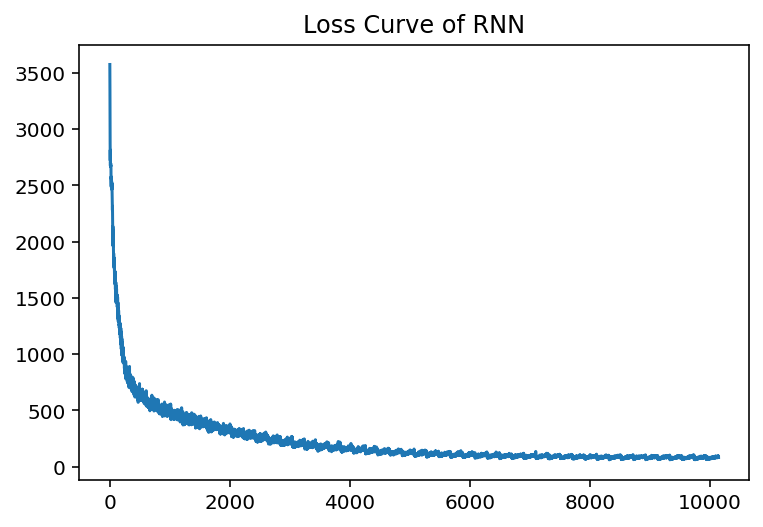

In [ ]:
plt.plot(np.arange(len(rnn_loss_list)), rnn_loss_list)
plt.title('Loss Curve of RNN')

In [ ]:
load_checkpoint(rnn_net, rnn_optim, rnn_loss_list, 'checkpoint', 'rnn.pt')

model rnn.pt	iters 10150	loss 81.57682037353516


In [ ]:
primer = torch.tensor([[bos_token]]).to(device)
valid_len = torch.full((1,), 600).to(device)
generate_output(rnn_net, primer, valid_len, 'output', "rnn")

In [ ]:
evaluate_net(rnn_net, train_iter, device)

Prediction Acc.: 0.2409


# CNN

In [ ]:
class CausalConv1d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
    super(CausalConv1d, self).__init__()
    self.padding = (kernel_size - 1) * dilation
    self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=self.padding, dilation=dilation, groups=groups, bias=bias)

  def forward(self, inputs):
    out = self.conv1d(inputs)
    if self.padding != 0:
      return out[:, :, : -self.padding]
    return out

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, res_channels, skip_channels, kernel_size, dilation):
    super(ResBlock, self).__init__()
    self.res_channels = res_channels
    self.conv_dilated = CausalConv1d(res_channels, res_channels * 2, kernel_size, dilation=dilation)
    self.conv_res = CausalConv1d(res_channels, res_channels, 1)
    self.conv_skip = CausalConv1d(res_channels, skip_channels, 1)

  def forward(self, inputs):
    dilated = self.conv_dilated(inputs)
    dilated_split = torch.split(dilated, self.res_channels, dim=1)
    gated = torch.tanh(dilated_split[0]) * torch.sigmoid(dilated_split[1])
    out = self.conv_res(gated)
    out += inputs
    skip = self.conv_skip(gated)
    return out, skip

In [ ]:
class ResStack(nn.Module):
  def __init__(self, res_channels, skip_channels, kernel_size, dilation_depth, num_repeat):
    super(ResStack, self).__init__()
    dilations = [2 ** d for d in range(dilation_depth)] * num_repeat
    self.res_blocks = nn.ModuleList([ResBlock(res_channels, skip_channels, kernel_size, d) for d in dilations])

  def forward(self, inputs):
    out = inputs
    skips = 0
    for res_block in self.res_blocks:
      out, skip = res_block(out)
      skips += skip
    return skips

In [ ]:
class WaveNet(nn.Module):
  def __init__(self, vocab_size, embedding_dim, res_channels, dilation_depth, num_repeat, kernel_size):
    super(WaveNet, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.causal = CausalConv1d(embedding_dim, res_channels, kernel_size)
    self.res_stack = ResStack(res_channels, embedding_dim, kernel_size, dilation_depth, num_repeat)
    self.relu1 = nn.ReLU()
    self.linear1 = nn.Conv1d(embedding_dim, vocab_size, 1)
    self.relu2 = nn.ReLU()
    self.linear2 = nn.Conv1d(vocab_size, vocab_size, 1)

  def forward(self, target, valid_len):
    embedded = self.embedding(target)
    embedded = embedded.permute(0,2,1)
    causal = self.causal(embedded)
    skips = self.res_stack(causal)
    linear = self.linear2(self.relu2(self.linear1(self.relu1(skips))))
    preds = linear.permute(0,2,1)
    return preds

In [ ]:
class CNN(nn.Module):
  def __init__(self, cnn, **kwargs):
    super(CNN, self).__init__(**kwargs)
    self.cnn = cnn

  def forward(self, tgt_array, tgt_valid_len):
    loss = 0

    preds = self.cnn(tgt_array, tgt_valid_len)

    T = tgt_array.shape[1]
    
    for t in range(T-1):
      loss += F.nll_loss(F.log_softmax(preds[:, t]), tgt_array[:, t+1], ignore_index=pad_token)

    preds = preds.argmax(dim=-1)
    
    return loss, preds
        
  def predict(self, tgt_array, tgt_valid_len):
    N, T = tgt_array.shape

    inputs = tgt_array[:, :1]
    outputs = [tgt_array[:, :1]]

    for t in range(torch.max(tgt_valid_len)-1):
      o = self.cnn(inputs, tgt_valid_len)
      if t+1 < T:
        output = tgt_array[:, t+1:t+2]
      else:
        output = o[:,-1:].argmax(dim=-1)
      outputs.append(output)
      inputs = torch.cat(outputs, dim=1)
      
    return inputs[:, 1:]

In [ ]:
seed(1)

vocab_size = 388+3
embedding_dim = 256
res_channels = 512
dilation_depth = 10
num_repeat = 1
kernel_size = 2

lr = 1e-3
epochs = 50
clip = 1

wave_net = WaveNet(vocab_size, embedding_dim, res_channels, dilation_depth, num_repeat, kernel_size)
cnn_net = CNN(wave_net).to(device)
cnn_optim = torch.optim.Adam(cnn_net.parameters(), lr=lr)
cnn_loss_list = []

In [ ]:
start = time.time()
train_net(cnn_net, cnn_optim, cnn_loss_list, train_iter, lr, epochs, clip, device)
end = time.time()
print("Elapsed time: ", end - start)
save_checkpoint(cnn_net, cnn_optim, cnn_loss_list, "checkpoint", "cnn.pt")

<ipython-input-25-36064f9e0e40>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss += F.nll_loss(F.log_softmax(preds[:, t]), tgt_array[:, t+1], ignore_index=pad_token)


iter 0 / 10150	Loss:	3575.409912
iter 203 / 10150	Loss:	801.517700
iter 406 / 10150	Loss:	616.704285
iter 609 / 10150	Loss:	518.552490
iter 812 / 10150	Loss:	458.577698
iter 1015 / 10150	Loss:	426.785645
iter 1218 / 10150	Loss:	366.128540
iter 1421 / 10150	Loss:	329.388428
iter 1624 / 10150	Loss:	301.539642
iter 1827 / 10150	Loss:	267.528503
iter 2030 / 10150	Loss:	265.190918
iter 2233 / 10150	Loss:	208.148788
iter 2436 / 10150	Loss:	213.431534
iter 2639 / 10150	Loss:	215.202850
iter 2842 / 10150	Loss:	199.065659
iter 3045 / 10150	Loss:	161.708664
iter 3248 / 10150	Loss:	192.144028
iter 3451 / 10150	Loss:	192.492233
iter 3654 / 10150	Loss:	181.768280
iter 3857 / 10150	Loss:	178.320129
iter 4060 / 10150	Loss:	174.242950
iter 4263 / 10150	Loss:	160.665161
iter 4466 / 10150	Loss:	178.880188
iter 4669 / 10150	Loss:	185.720688
iter 4872 / 10150	Loss:	152.540436
iter 5075 / 10150	Loss:	165.119690
iter 5278 / 10150	Loss:	171.498535
iter 5481 / 10150	Loss:	181.857224
iter 5684 / 10150	Loss:	17

Text(0.5, 1.0, 'Loss Curve of CNN')

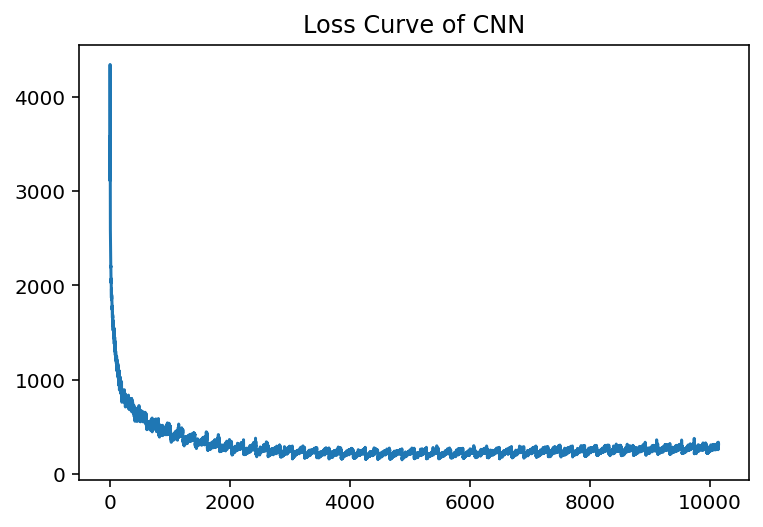

In [ ]:
plt.plot(np.arange(len(cnn_loss_list)), cnn_loss_list)
plt.title('Loss Curve of CNN')

In [ ]:
load_checkpoint(cnn_net, cnn_optim, cnn_loss_list, 'checkpoint', 'cnn.pt')

model cnn.pt	iters 10150	loss 310.1690673828125


In [ ]:
primer = torch.tensor([[bos_token]]).to(device)
valid_len = torch.full((1,), 600).to(device)
generate_output(cnn_net, primer, valid_len, 'output', "cnn")

In [ ]:
evaluate_net(cnn_net, train_iter, device)

Prediction Acc.: 0.1805


# Transformer

In [ ]:
def masked_softmax(X, valid_length):
  """
  inputs:
    X: 3-D tensor
    valid_length: 1-D or 2-D tensor
  """
  mask_value = -1e7 

  if len(X.shape) == 2:
    X = X.unsqueeze(1)

  N, n, m = X.shape

  if len(valid_length.shape) == 1:
    valid_length = valid_length.repeat_interleave(n, dim=0)
  else:
    valid_length = valid_length.reshape((-1,))

  mask = torch.arange(m)[None, :].to(X.device) >= valid_length[:, None]
  X.view(-1, m)[mask] = mask_value

  Y = torch.softmax(X, dim=-1)

  
  return Y

In [ ]:
class DotProductAttention(nn.Module): 
  def __init__(self):
      super(DotProductAttention, self).__init__()

  def forward(self, query, key, value, valid_length=None):
    """
    inputs:
      query: tensor of size (B, n, d)
      key: tensor of size (B, m, d)
      value: tensor of size (B, m, dim_v)
      valid_length: (B, )

      B is the batch_size, n is the number of queries, m is the number of <key, value> pairs,
      d is the feature dimension of the query, and dim_v is the feature dimension of the value.

    Outputs:
      attention: tensor of size (B, n, dim_v), weighted sum of values
    """
    d = key.shape[2]
    a = torch.bmm(query, key.permute(0,2,1))/(d ** 0.5)
    b = masked_softmax(a, valid_length)
    attention = torch.bmm(b, value)

    return attention

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, d_k, num_heads,  **kwargs):
    super(MultiHeadAttention, self).__init__()
    """
    Inputs:
      d_model: int, the same d_model in paper, feature dimension of query/key/values
      d_k: int, feature projected dimension of query/key/value, we follow the setting in the paper, where d_v=d_k=d_q
      num_heads: int, number of heads used for this MultiHeadAttention
    """
    self.num_heads = num_heads
    self.attention = DotProductAttention()
    self.W_q = nn.Linear(d_model, num_heads * d_k)
    self.W_k = nn.Linear(d_model, num_heads * d_k)
    self.W_v = nn.Linear(d_model, num_heads * d_k)
    self.W_o = nn.Linear(num_heads * d_k, d_model)

  def forward(self, query, key, value, valid_length):
    """
    inputs:
      query: tensor of size (B, T, d_model)
      key: tensor of size (B, T, d_model)
      value: tensor of size (B, T, d_model)
      valid_length: (B, )

      B is the batch_size, T is length of sequence, d_model is the feature dimensions of query,
      key, and value.

    Outputs:
      attention (B, T, d_model)
      """
    query = self.W_q(query)
    # query (B, T_q, num_heads * d_k)
    key = self.W_k(key)
    # key (B, T, num_heads * d_k)
    value = self.W_v(value)
    # value (B, T, num_heads * d_k)

    B, T, num_hiddens = key.shape
    _, T_q, _ = query.shape
    d_k = num_hiddens // self.num_heads

    query = query.reshape(B, T_q, self.num_heads, -1).permute(0,2,1,3).reshape(-1, T_q, d_k)
    # query (B * num_heads, T_q, d_k)
    key = key.reshape(B, T, self.num_heads, -1).permute(0,2,1,3).reshape(-1, T, d_k)
    # key (B * num_heads, T, d_k)
    value = value.reshape(B, T, self.num_heads, -1).permute(0,2,1,3).reshape(-1, T, d_k)
    # value (B * num_heads, T, d_k)

    valid_length = torch.repeat_interleave(valid_length, repeats=self.num_heads, dim=0)

    attention = self.attention(query, key, value, valid_length)
    # attention (B * num_heads, T_q, d_k)
    attention = attention.reshape(-1, self.num_heads, T_q, d_k).permute(0,2,1,3).reshape(B, T_q, -1)
    # attention (B, T_q, num_heads * d_k)
    attention = self.W_o(attention)
    # attention (B, T_q, d_model)

    return attention

In [ ]:
class PositionWiseFFN(nn.Module):
  def __init__(self, input_size, ffn_l1_size, ffn_l2_size):
    super(PositionWiseFFN, self).__init__()
    """
    Inputs:
      input_size: int, feature dimension of the input
      fnn_l1_size: int, feature dimension of the output after the first position-wise FFN.
      fnn_l2_size: int, feature dimension of the output after the second position-wise FFN.
    """
    self.ffn_l1 = nn.Linear(input_size, ffn_l1_size)
    self.relu = nn.ReLU()
    self.ffn_l2 = nn.Linear(ffn_l1_size, ffn_l2_size)

  def forward(self, X):
    """
    Input:
      X: tensor of size (N, T, D_in)
    Output:
      o: tensor of size (N, T, D_out)
    """
    o = self.ffn_l2(self.relu(self.ffn_l1(X)))
    return o

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, dim, device, max_len=100000):
    super(PositionalEncoding, self).__init__()
    """
    Inputs:
      dim: feature dimension of the positional encoding
    """
    self.pe = torch.zeros((1, max_len, dim), device=device)
    X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, dim, 2, dtype=torch.float32) / dim)
    self.pe[:, :, 0::2] = torch.sin(X)
    self.pe[:, :, 1::2] = torch.cos(X)


  def forward(self, X):
    """
    Inputs:
      X: tensor of size (N, T, D_in)
    Output:
      Y: tensor of the same size of X
    """
    N, T, D_in = X.shape
    Y = X + self.pe[:, :T, :]

    return Y

In [ ]:
class AddNorm(nn.Module):
    def __init__(self, dropout, embedding_size):
        super(AddNorm, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(embedding_size)

    def forward(self, X, Y):
        return self.norm(self.dropout(Y) + X)

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, d_model, d_k, ffn_l1_size, ffn_l2_size, num_heads,
             dropout, **kwargs):
    super(DecoderBlock, self).__init__()
    """
    Inputs:
      d_model: int, feature dimension of query/key/value
      d_k: int, feature projected dimension of query/key/value, we follow the setting in the paper, where d_v=d_k=d_q
      fnn_l1_size: int, feature dimension of the output after the first position-wise FFN.
      fnn_l2_size: int, feature dimension of the output after the second position-wise FFN.
      num_heads: int, number of head for multi-head attention layer.
      dropout: dropout probability for dropout layer.
      
    """
    self.attention = MultiHeadAttention(d_model, d_k, num_heads)
    self.addnorm_1 = AddNorm(dropout, d_model)
    self.ffn = PositionWiseFFN(d_model, ffn_l1_size, ffn_l2_size)
    self.addnorm_2 = AddNorm(dropout, d_model)

  def forward(self, X, valid_len):
    """
    Inputs:
      X: tensor of size (N, T, D), embedded input sequences
      **kwargs: other arguments you think is necessary for implementation
    Outputs:
      Y: tensor of size (N, T, D_out)
      
      Feel free to output variables if necessary.
    """
    N, T, D = X.shape
    if self.training:
      dec_valid_len = torch.arange(1, T+1).repeat(N, 1).to(device)
    else:
      dec_valid_len = torch.full((N,), T).to(device)
    X = self.addnorm_1(X, self.attention(X, X, X, dec_valid_len))
    Y = self.addnorm_2(X, self.ffn(X))

    return Y

In [ ]:
class TransformerDecoder(nn.Module):
  def __init__(self, vocab_size, d_model, ffn_l1_size, ffn_l2_size,
             num_heads, num_layers, dropout, device):
    super(TransformerDecoder, self).__init__()
    """
    Inputs:
      d_model: int, feature dimension of query/key/value
      fnn_l1_size: int, feature dimension of the output after the first position-wise FFN.
      fnn_l2_size: int, feature dimension of the output after the second position-wise FFN.
      num_heads: int, number of head for multi-head attention layer.
      dropout: dropout probability for dropout layer.
      num_layers: number of decoder blocks
    """
    self.d_model = d_model
    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_enc = PositionalEncoding(d_model, device=device)
    self.layers = nn.ModuleList([DecoderBlock(d_model, d_model // num_heads, ffn_l1_size, ffn_l2_size, num_heads, dropout) for _ in range(num_layers)])
    self.dense = nn.Linear(d_model, vocab_size)


  def forward(self, X, valid_len):
    """
    Inputs:
      X: tensor of size (N, T, D), embedded input sequences
      valid_length: tensor of size (N,), valid lengths for each sequence
    """
    X = self.pos_enc(self.embedding(X) * (self.d_model ** 0.5))
    for layer in self.layers:
      X = layer(X, valid_len)
    Y = self.dense(X)
    
    return Y

In [ ]:
class Transformer(nn.Module):
  """The base class for the encoder-decoder architecture."""
  def __init__(self, decoder, **kwargs):
    super(Transformer, self).__init__(**kwargs)
    self.decoder = decoder

  def forward(self, tgt_array, tgt_valid_len):
    """Forward function"""
    loss = 0

    preds = self.decoder(tgt_array, tgt_valid_len)

    T = tgt_array.shape[1]
    
    for t in range(T-1):
      loss += F.nll_loss(F.log_softmax(preds[:, t]), tgt_array[:, t+1], ignore_index=pad_token)

    preds = preds.argmax(dim=-1)
    
    return loss, preds
        
  def predict(self, tgt_array, tgt_valid_len):
    N, T = tgt_array.shape

    inputs = tgt_array[:, :1]
    outputs = [tgt_array[:, :1]]

    for t in range(torch.max(tgt_valid_len)-1):
      o = self.decoder(inputs, tgt_valid_len)
      if t+1 < T:
        output = tgt_array[:, t+1:t+2]
      else:
        output = o[:,-1:].argmax(dim=-1)
      outputs.append(output)
      inputs = torch.cat(outputs, dim=1)
      
    return inputs[:, 1:]

In [ ]:
seed(1)

vocab_size = 388+3
d_model = 256 #512
ffn_l1_size = 512 #2048
ffn_l2_size = d_model
num_heads = 8
num_layers = 8 #6
dropout = 0.1

lr = 1e-3
epochs = 50 #250
clip = 1

decoder = TransformerDecoder(vocab_size, d_model, ffn_l1_size, ffn_l2_size,
                             num_heads, num_layers, dropout, device=device)
transformer_net = Transformer(decoder).to(device)
transformer_optim = torch.optim.Adam(transformer_net.parameters(), lr=lr)
transformer_loss_list = []

In [ ]:
start = time.time()
train_net(transformer_net, transformer_optim, transformer_loss_list, train_iter, lr, epochs, clip, device)
end = time.time()
print("Elapsed time: ", end - start)
save_checkpoint(transformer_net, transformer_optim, transformer_loss_list, "checkpoint", "transformer.pt")

<ipython-input-18-2d6d80aa0ded>:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss += F.nll_loss(F.log_softmax(preds[:, t]), tgt_array[:, t+1], ignore_index=pad_token)


iter 0 / 10150	Loss:	3654.937500
iter 203 / 10150	Loss:	1494.294189
iter 406 / 10150	Loss:	1012.245361
iter 609 / 10150	Loss:	757.851807
iter 812 / 10150	Loss:	680.383606
iter 1015 / 10150	Loss:	602.159424
iter 1218 / 10150	Loss:	611.789001
iter 1421 / 10150	Loss:	557.963440
iter 1624 / 10150	Loss:	495.845428
iter 1827 / 10150	Loss:	510.629181
iter 2030 / 10150	Loss:	462.182922
iter 2233 / 10150	Loss:	429.278900
iter 2436 / 10150	Loss:	438.485535
iter 2639 / 10150	Loss:	436.460358
iter 2842 / 10150	Loss:	405.431213
iter 3045 / 10150	Loss:	424.972504
iter 3248 / 10150	Loss:	424.536377
iter 3451 / 10150	Loss:	374.909210
iter 3654 / 10150	Loss:	363.345245
iter 3857 / 10150	Loss:	380.718689
iter 4060 / 10150	Loss:	365.834473
iter 4263 / 10150	Loss:	362.439941
iter 4466 / 10150	Loss:	355.280121
iter 4669 / 10150	Loss:	343.524963
iter 4872 / 10150	Loss:	384.004761
iter 5075 / 10150	Loss:	339.634888
iter 5278 / 10150	Loss:	343.133820
iter 5481 / 10150	Loss:	375.469696
iter 5684 / 10150	Loss:	

Text(0.5, 1.0, 'Loss Curve of Transformer')

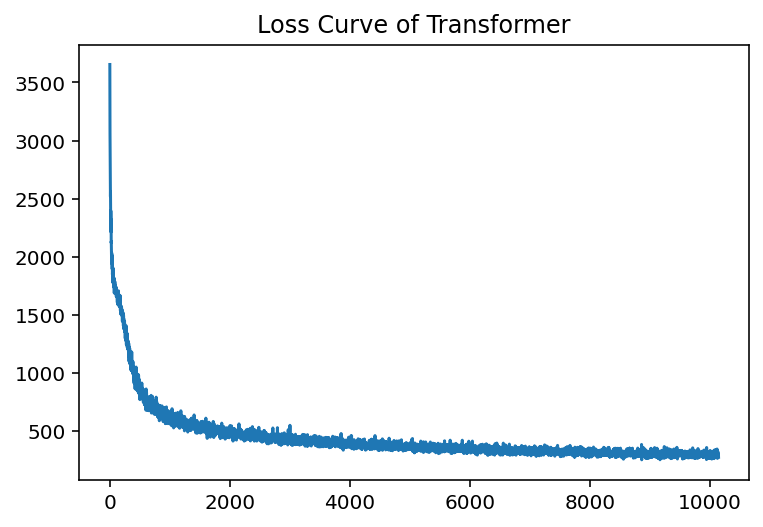

In [ ]:
plt.plot(np.arange(len(transformer_loss_list)), transformer_loss_list)
plt.title('Loss Curve of Transformer')

In [ ]:
load_checkpoint(transformer_net, transformer_optim, transformer_loss_list, 'checkpoint', 'transformer.pt')

model transformer.pt	iters 10150	loss 271.7147216796875


In [ ]:
primer = torch.tensor([[bos_token]]).to(device)
valid_len = torch.full((1,), 600).to(device)
generate_output(transformer_net, primer, valid_len, 'output', "transformer")

In [ ]:
evaluate_net(transformer_net, train_iter, device)

# VAE

In [ ]:
class VAEEncoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, latent_dim):
    super(VAEEncoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of vallina RNN
    """
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
    self.hid2mu = nn.Linear(2*hidden_size, latent_dim)
    self.hid2logvar = nn.Linear(2*hidden_size, latent_dim)
    self.kld = 0

  def forward(self, src, src_len):
    """
    Inputs:
      source: tensor of size (N, T), where N is the batch size, T is the length of the sequence(s)
      valid_len: tensor of size (N,), indicating the valid length of sequence(s) (the length before padding)
    """
    embedded = self.embedding(src)
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), batch_first=True, enforce_sorted=False)
    packed_outputs, hidden = self.rnn(packed_embedded)
    outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
    hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
    mu = self.hid2mu(hidden)
    logvar = self.hid2logvar(hidden)
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    z = mu + (eps * std)
    self.kld = -0.5*torch.sum(logvar-mu.pow(2)-logvar.exp()+1, dim=1).mean()
    return z


In [ ]:
class VAEDecoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, latent_dim):
    super(VAEDecoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of the hidden state of vanilla RNN
    """
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.GRU(embedding_dim+latent_dim, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, vocab_size)
    
  def forward(self, z, target, h=None):
    embedded = self.embedding(target)
    N, T, _ = embedded.shape

    zs = torch.cat([z]*T, dim=1).view(N, T, -1)
    concat = torch.cat([embedded, zs], dim=2)
    
    o, h = self.rnn(concat, h)
    pred = self.fc(o)
    return pred, h

In [ ]:
class VAE(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, latent_dim):
    super(VAE, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.latent_dim = latent_dim

    self.encoder = VAEEncoder(vocab_size, embedding_dim, hidden_size, num_layers, latent_dim)
    self.decoder = VAEDecoder(vocab_size, embedding_dim, hidden_size, num_layers, latent_dim)
        
  def forward(self, tgt_array, tgt_valid_len):
    rec_loss = 0

    z = self.encoder(tgt_array, tgt_valid_len)
    preds, _ = self.decoder(z, tgt_array)

    T = tgt_array.shape[1]
    
    for t in range(T-1):
      rec_loss += F.nll_loss(F.log_softmax(preds[:, t]), tgt_array[:, t+1], ignore_index=pad_token)
    
    elbo = rec_loss + self.encoder.kld
    preds = preds.argmax(dim=-1)
    
    return elbo, preds

  def predict(self, target, valid_len):
    N, T = target.shape
    h = target.new_zeros(self.num_layers, N, self.hidden_size).float()
    z = torch.randn(N, self.latent_dim).to(device)

    inputs = target[:, :1]
    preds = []

    for t in range(torch.max(valid_len)-1):
      pred, h = self.decoder(z, inputs, h)
      if t+1 < T:
        inputs = target[:, t+1:t+2]
      else:
        inputs = pred.argmax(dim=-1)
      preds.append(inputs)
      
    preds = torch.cat(preds, dim=1)
    return preds

In [ ]:
seed(1)

vocab_size = 388+3
embedding_dim = 256
hidden_size = 512
num_layers = 3
latent_dim = 64

lr = 1e-3
epochs = 50
clip = 0.1

vae_net = VAE(vocab_size, embedding_dim, hidden_size, num_layers, latent_dim).to(device)
vae_optim = torch.optim.Adam(vae_net.parameters(), lr=lr)
vae_loss_list = []

In [ ]:
start = time.time()
train_net(vae_net, vae_optim, vae_loss_list, train_iter, lr, epochs, clip, device)
end = time.time()
print("Elapsed time: ", end - start)
save_checkpoint(vae_net, vae_optim, vae_loss_list, "checkpoint", "vae.pt")

<ipython-input-12-1a1ad39bb55e>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  rec_loss += F.nll_loss(F.log_softmax(preds[:, t]), tgt_array[:, t+1], ignore_index=pad_token)


iter 0 / 10150	Loss:	3573.935547
iter 203 / 10150	Loss:	1048.970459
iter 406 / 10150	Loss:	713.945801
iter 609 / 10150	Loss:	621.548523
iter 812 / 10150	Loss:	528.903320
iter 1015 / 10150	Loss:	486.394196
iter 1218 / 10150	Loss:	459.722443
iter 1421 / 10150	Loss:	389.052094
iter 1624 / 10150	Loss:	390.250214
iter 1827 / 10150	Loss:	307.711395
iter 2030 / 10150	Loss:	294.359894
iter 2233 / 10150	Loss:	277.167847
iter 2436 / 10150	Loss:	238.532990
iter 2639 / 10150	Loss:	199.799622
iter 2842 / 10150	Loss:	208.542252
iter 3045 / 10150	Loss:	181.151749
iter 3248 / 10150	Loss:	186.151840
iter 3451 / 10150	Loss:	173.012436
iter 3654 / 10150	Loss:	156.886917
iter 3857 / 10150	Loss:	145.644150
iter 4060 / 10150	Loss:	139.247269
iter 4263 / 10150	Loss:	121.506706
iter 4466 / 10150	Loss:	121.243065
iter 4669 / 10150	Loss:	117.020844
iter 4872 / 10150	Loss:	110.532516
iter 5075 / 10150	Loss:	108.282112
iter 5278 / 10150	Loss:	100.613373
iter 5481 / 10150	Loss:	107.031944
iter 5684 / 10150	Loss:	1

Text(0.5, 1.0, 'Loss Curve of VAE')

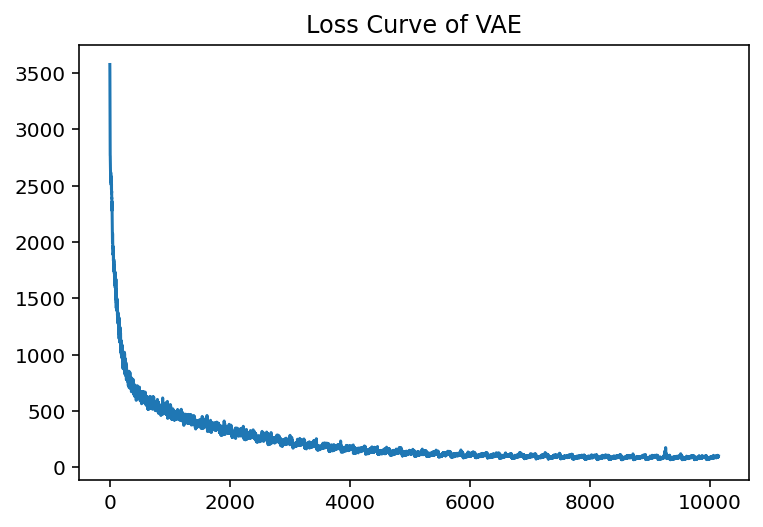

In [ ]:
plt.plot(np.arange(len(vae_loss_list)), vae_loss_list)
plt.title('Loss Curve of VAE')

In [ ]:
load_checkpoint(vae_net, vae_optim, vae_loss_list, 'checkpoint', 'vae.pt')

model vae.pt	iters 10150	loss 98.5639877319336


In [ ]:
primer = torch.tensor([[bos_token]]).to(device)
valid_len = torch.full((1,), 600).to(device)
generate_output(vae_net, primer, valid_len, 'output', "vae")

In [ ]:
evaluate_net(vae_net, train_iter, device)

Prediction Acc.: 0.2313


# GAN

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dense_size):
    super(Discriminator, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of vallina RNN
    """
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
    self.fc1 = nn.Linear(2*hidden_size, dense_size)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout()
    self.fc2 = nn.Linear(dense_size, 1)

  def forward(self, src):
    """
    Inputs:
      source: tensor of size (N, T), where N is the batch size, T is the length of the sequence(s)
      valid_len: tensor of size (N,), indicating the valid length of sequence(s) (the length before padding)
    """
    embedded = self.embedding(src)
    outputs, hidden = self.rnn(embedded)
    h = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
    o = self.fc2(self.dropout(self.relu(self.fc1(h))))
    return o, h


In [ ]:
class Generator(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, latent_dim):
    super(Generator, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of the hidden state of vanilla RNN
    """
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.latent_dim = latent_dim

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.GRU(embedding_dim+latent_dim, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, vocab_size)
    
  def forward(self, z):
    N, _ = z.shape
    primer = z.new_full((N, 1), bos_token).int()
    h = z.new_zeros(self.num_layers, N, self.hidden_size).float()

    inputs = primer
    preds = [primer]
    
    for t in range(MAX_LEN-1):
      inputs_embedded = self.embedding(inputs)
      concat = torch.cat((inputs_embedded, z.unsqueeze(1)), dim=2)
      o, h = self.rnn(concat, h)
      pred = self.fc(o)
      inputs = pred.argmax(dim=-1)
      preds.append(inputs)
    
    preds = torch.cat(preds, dim=1)
    return preds

  def predict(self, target, valid_len):
    N, T = target.shape
    h = target.new_zeros(self.num_layers, N, self.hidden_size).float()
    z = torch.randn(N, self.latent_dim).to(device)

    inputs = target[:, :1]
    preds = []

    for t in range(torch.max(valid_len)-1):
      inputs_embedded = self.embedding(inputs)
      concat = torch.cat((inputs_embedded, z.unsqueeze(1)), dim=2)
      o, h = self.rnn(concat, h)
      pred = self.fc(o)
      if t+1 < T:
        inputs = target[:, t+1:t+2]
      else:
        inputs = pred.argmax(dim=-1)
      preds.append(inputs)
      
    preds = torch.cat(preds, dim=1)
    return preds

In [ ]:
def train_gan(d_net, g_net, d_optim, g_optim, d_loss_list, g_loss_list, latent_dim, train_iter, lr, epochs, clip, device):
  #training
  d_net = d_net.to(device)
  g_net = g_net.to(device)

  print_interval = len(train_iter)
  prev_epochs = len(d_loss_list) // len(train_iter)
  total_iter = (prev_epochs + epochs) * len(train_iter)
  for i in range(0, len(d_loss_list), len(train_iter)):
    print('iter {} / {}\td_loss:\t{:.6f}\tg_loss:\t{:.6f}'.format(i, total_iter, d_loss_list[i], g_loss_list[i]))

  bce_loss = nn.BCEWithLogitsLoss()
  mse_loss = nn.MSELoss()
  
  for e in range(prev_epochs, prev_epochs + epochs):
    d_net.train()
    g_net.train()
    for i, train_data in enumerate(train_iter):
      train_data = [ds.to(device) for ds in train_data]

      X = train_data[0]
      batch_size = X.shape[0]
      Z = torch.randn(batch_size, latent_dim).to(device)

      ones = torch.ones((batch_size, 1), device=device)
      zeros = torch.zeros((batch_size, 1), device=device)

      # Update discriminator
      real_Y, real_h = d_net(X)
      fake_X = g_net(Z)
      # Do not need to compute gradient for `g_net`, detach it from computing gradients.
      fake_Y, fake_h = d_net(fake_X.detach())
      d_loss = (bce_loss(real_Y, ones) + bce_loss(fake_Y, zeros)) / 2
      d_optim.zero_grad()
      d_loss.backward()
      d_optim.step()

      # Update generator
      # We could reuse `fake_X` from `update_D` to save computation
      # Recomputing `fake_Y` is needed since `d_net` is changed
      real_Y, real_h = d_net(X)
      fake_Y, fake_h = d_net(fake_X)
      # g_loss = bce_loss(fake_Y, ones)
      g_loss = mse_loss(real_h.detach(), fake_h)
      g_optim.zero_grad()
      g_loss.backward()
      g_optim.step()

      d_loss_list.append(d_loss.detach().cpu())
      g_loss_list.append(g_loss.detach().cpu())

      step = i + e * len(train_iter)
      if step % print_interval == 0:
        print('iter {} / {}\td_loss:\t{:.6f}\tg_loss:\t{:.6f}'.format(step, total_iter, d_loss.detach(), g_loss.detach()))

In [ ]:
seed(1)

vocab_size = 388+3
embedding_dim = 256
hidden_size = 512
num_layers = 3
latent_dim = 64
dense_size = hidden_size

lr = 1e-3
epochs = 50
clip = 1

d_net = Discriminator(vocab_size, embedding_dim, hidden_size, num_layers, dense_size).to(device)
d_optim = torch.optim.Adam(d_net.parameters(), lr=lr)
d_loss_list = []

g_net = Generator(vocab_size, embedding_dim, hidden_size, num_layers, latent_dim).to(device)
g_optim = torch.optim.Adam(g_net.parameters(), lr=lr)
g_loss_list = []

In [ ]:
start = time.time()
train_gan(d_net, g_net, d_optim, g_optim, d_loss_list, g_loss_list, latent_dim, train_iter, lr, epochs, clip, device)
end = time.time()
print("Elapsed time: ", end - start)
save_checkpoint(d_net, d_optim, d_loss_list, "checkpoint", "discriminator.pt")
save_checkpoint(g_net, g_optim, g_loss_list, "checkpoint", "generator.pt")

In [ ]:
plt.plot(np.arange(len(g_loss_list)), g_loss_list, label='G')
plt.plot(np.arange(len(d_loss_list)), d_loss_list, label='D')
plt.legend()
plt.title('Loss Curve of GAN')

In [ ]:
load_checkpoint(d_net, d_optim, d_loss_list, 'checkpoint', 'discriminator.pt')
load_checkpoint(g_net, g_optim, g_loss_list, 'checkpoint', 'generator.pt')

In [ ]:
primer = torch.tensor([[bos_token]]).to(device)
valid_len = torch.full((1,), 600).to(device)
generate_output(g_net, primer, valid_len, 'output', "gan")

In [ ]:
evaluate_net(g_net, train_iter, device)

# A2C

In [ ]:
class A2C(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
    super(A2C, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of vallina RNN
    """
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)
    self.actor_fc = nn.Linear(hidden_size, vocab_size)
    self.critic_fc = nn.Linear(hidden_size, 1)

  def forward(self, target, valid_len):
    loss = 0
    policies = []
    values = []
    gamma = 0.99
      
    embedded = self.embedding(target)
    # embedded (B, n, embedding_dim)

    N, T = target.shape
    h = target.new_zeros(self.num_layers, N, self.hidden_size).float()

    input = embedded[:, 0].unsqueeze(1)
    # input (B, n, embedding_dim)
    o, h = self.rnn(input, h)
    # o (B, n, hidden_size)
    # h (num_layers, B, hidden_size)
    policy = self.actor_fc(o)
    # policy (B, n, vocab_size)
    value = self.critic_fc(o)
    # value (B, n, 1)

    policies.append(policy)
    values.append(value)

    for t in range(T-1):
      policy = policies[-1]
      value = values[-1]
      next_input = embedded[:, t+1].unsqueeze(1)
      o, h = self.rnn(next_input, h)
      next_policy = self.actor_fc(o)
      next_value = self.critic_fc(o)

      log_prob = F.log_softmax(policy[:, 0])
      # log_prob (B, vocab_size)
      nll_loss = F.nll_loss(log_prob, target[:, t+1], ignore_index=pad_token, reduction='none')
      reward = -nll_loss
      # reward = (policy[:, 0].argmax(-1) == target[:, t+1]).float()
      # reward (B,)
      target_value = reward + gamma * next_value[:, 0, 0]
      # target_value (B,)
      advantage = target_value - value[:, 0, 0]
      # advantage (B,)

      actor_loss = (-log_prob * advantage.unsqueeze(-1)).mean()
      critic_loss = F.mse_loss(value[:, 0, 0], target_value)
      loss += actor_loss + critic_loss

      policies.append(next_policy)
      values.append(next_value)
        
    preds = torch.cat(policies, dim=1).argmax(dim=-1)
    # preds (B, T) (32, 600)
    return loss, preds
  
  def predict(self, target, valid_len):
    N, T = target.shape
    h = target.new_zeros(self.num_layers, N, self.hidden_size).float()

    inputs = target[:, :1]
    preds = []

    for t in range(torch.max(valid_len)-1):
      inputs_embedded = self.embedding(inputs)
      o, h = self.rnn(inputs_embedded, h)
      if t+1 < T:
        inputs = target[:, t+1:t+2]
      else:
        pred = self.actor_fc(o)
        inputs = pred.argmax(dim=-1)
      preds.append(inputs)
      
    preds = torch.cat(preds, dim=1)
    return preds

In [ ]:
seed(1)

vocab_size = 388+3
embedding_dim = 256
hidden_size = 512
num_layers = 3

lr = 1e-3
epochs = 50
clip = 1

a2c_net = A2C(vocab_size, embedding_dim, hidden_size, num_layers).to(device)
a2c_optim = torch.optim.Adam(a2c_net.parameters(), lr=lr)
a2c_loss_list = []

In [ ]:
start = time.time()
train_net(a2c_net, a2c_optim, a2c_loss_list, debug_iter, lr, epochs, clip, device)
end = time.time()
print("Elapsed time: ", end - start)
save_checkpoint(a2c_net, a2c_optim, a2c_loss_list, "checkpoint", "a2c.pt")

In [ ]:
plt.plot(np.arange(len(a2c_loss_list)), a2c_loss_list)
plt.title('Loss Curve of A2C')

In [ ]:
load_checkpoint(a2c_net, a2c_optim, a2c_loss_list, 'checkpoint', 'a2c.pt')

In [ ]:
primer = torch.tensor([[bos_token]]).to(device)
valid_len = torch.full((1,), 600).to(device)
generate_output(a2c_net, primer, valid_len, 'output', "a2c")

In [ ]:
evaluate_net(a2c_net, debug_iter, device)